In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.datasets import imdb

**Step 1** - In this step, we load the IMDb movie reviews dataset, which consists of real user-generated movie reviews labeled as positive or negative sentiment. To control vocabulary size and reduce noise, we limit the dataset to the 10,000 most frequent words.

In [20]:
# Load IMDb dataset (top 10,000 most frequent words)
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

In [21]:
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

print("\nExample review (encoded):")
print(X_train[0])

print("\nLabel (0 = negative, 1 = positive):")
print(y_train[0])

Training samples: 25000
Testing samples: 25000

Example review (encoded):
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345,

**Step 2** - The IMDb dataset stores reviews as integer sequences to optimize storage and computation.
In this step, we decode these sequences back into readable text to better understand the data, validate realism, and prepare for text preprocessing.

In [22]:
word_index = imdb.get_word_index()

word_index = {word: index + 3 for word, index in word_index.items()}

word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2

In [23]:
reverse_word_index = {index: word for word, index in word_index.items()}

In [24]:
def decode_review(encoded_review):
  return " ".join(
      [reverse_word_index.get(i, "<UNK>") for i in encoded_review]
  )

  print(decode_review(X_train[0]))

In [25]:
for i in range(3):
  print(f"\nReview [{i + 1}] | Label:", "Positive" if y_train[i] == 1 else "Negative")
  print(decode_review(X_train[i][:500]))


Review [1] | Label: Positive
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing

**Step 3** - In this project, stemming and lemmatization are intentionally skipped to preserve semantic meaning and avoid overly aggressive word reduction.
Instead, vectorization techniques such as TF-IDF will handle term importance naturally.

In [26]:
import re

def clean_text(text):
    # Remove special tokens
    text = text.replace("<START>", "")
    text = text.replace("<PAD>", "")
    text = text.replace("<UNK>", "")

    # Lowercase
    text = text.lower()

    # Remove non-letter characters
    text = re.sub(r"[^a-z\s]", "", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text


In [27]:
# Decode and clean training data
X_train_text = [clean_text(decode_review(review)) for review in X_train]
X_test_text = [clean_text(decode_review(review)) for review in X_test]

In [28]:
print("Original decoded review:\n")
print(decode_review(X_train[0])[:400])

print("\nCleaned review:\n")
print(X_train_text[0][:400])

Original decoded review:

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it

Cleaned review:

this film was just brilliant casting location scenery story direction everyones really suited the part they played and you could just imagine being there robert is an amazing actor and now the same being director father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant s


**Step 4** - In this step, textual data is converted into numerical feature vectors using Bag of Words and TF-IDF representations.
Bag of Words captures word frequency, while TF-IDF additionally weighs terms based on their importance across documents, often improving model performance on real-world text data.

In [29]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [30]:
# Bag of Words vectorizer
bow_vectorizer = CountVectorizer(
    max_features=5000,
    stop_words="english"
)

# Fit on training data, transform both sets
X_train_bow = bow_vectorizer.fit_transform(X_train_text)
X_test_bow = bow_vectorizer.transform(X_test_text)

print("BoW feature shape:", X_train_bow.shape)

BoW feature shape: (25000, 5000)


In [31]:
# TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english"
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

print("TF-IDF feature shape:", X_train_tfidf.shape)

TF-IDF feature shape: (25000, 5000)


In [32]:
# View some feature names
print("BoW features:", bow_vectorizer.get_feature_names_out()[:20])
print("\nTF-IDF features:", tfidf_vectorizer.get_feature_names_out()[:20])

BoW features: ['abandoned' 'abc' 'abilities' 'ability' 'able' 'abraham' 'absence'
 'absent' 'absolute' 'absolutely' 'absurd' 'absurdity' 'abuse' 'abused'
 'abusive' 'abysmal' 'academy' 'accent' 'accents' 'accept']

TF-IDF features: ['abandoned' 'abc' 'abilities' 'ability' 'able' 'abraham' 'absence'
 'absent' 'absolute' 'absolutely' 'absurd' 'absurdity' 'abuse' 'abused'
 'abusive' 'abysmal' 'academy' 'accent' 'accents' 'accept']


**Step 5** - Logistic Regression performs well on sentiment classification, particularly when combined with TF-IDF features.
TF-IDF improves performance by reducing the influence of common words and emphasizing informative terms, making it more suitable for real-world NLP tasks.

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [34]:
# Logistic Regression with BoW
lr_bow = LogisticRegression(max_iter=1000)
lr_bow.fit(X_train_bow, y_train)

# Predictions
y_pred_bow = lr_bow.predict(X_test_bow)

# Evaluation
print("Logistic Regression (BoW)")
print("Accuracy:", accuracy_score(y_test, y_pred_bow))
print(classification_report(y_test, y_pred_bow))

Logistic Regression (BoW)
Accuracy: 0.84384
              precision    recall  f1-score   support

           0       0.84      0.85      0.84     12500
           1       0.85      0.84      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



In [35]:
# Logistic Regression with TF-IDF
lr_tfidf = LogisticRegression(max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)

# Predictions
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)

# Evaluation
print("Logistic Regression (TF-IDF)")
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

Logistic Regression (TF-IDF)
Accuracy: 0.87812
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



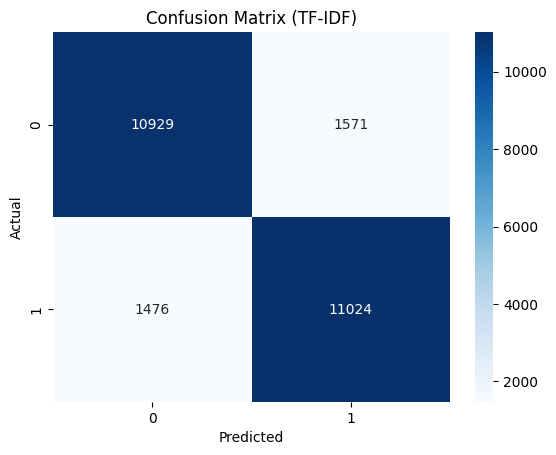

In [36]:
cm = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (TF-IDF)")
plt.show()

Many misclassified reviews contain mixed or sarcastic language, where positive and negative expressions coexist.
Traditional bag-of-words-based models struggle to capture context, negation scope, and sarcasm, which explains these prediction errors.

In [37]:
# Find misclassified indices (TF-IDF model)
misclassified_indices = np.where(y_test != y_pred_tfidf)[0]

print("Number of misclassified reviews:", len(misclassified_indices))


Number of misclassified reviews: 3047


In [38]:
bow_accuracy = accuracy_score(y_test, y_pred_bow)
tfidf_accuracy = accuracy_score(y_test, y_pred_tfidf)

print("BoW Accuracy:", bow_accuracy)
print("TF-IDF Accuracy:", tfidf_accuracy)

BoW Accuracy: 0.84384
TF-IDF Accuracy: 0.87812


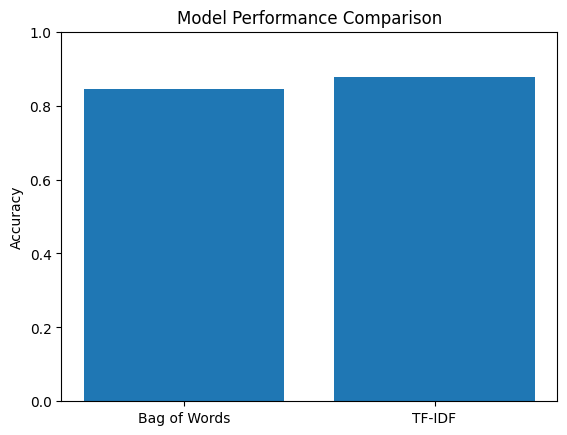

In [39]:
import matplotlib.pyplot as plt

models = ["Bag of Words", "TF-IDF"]
accuracies = [bow_accuracy, tfidf_accuracy]

plt.figure()
plt.bar(models, accuracies)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.show()


**Step 7** - The plot shows that TF-IDF slightly outperforms the Bag of Words representation.
This improvement is expected, as TF-IDF reduces the impact of very common words while emphasizing more informative terms, making it better suited for real-world text classification tasks.

In a production setting, further improvements could include n-grams, sentiment lexicons, or transformer-based models such as BERT to better capture context and semantic meaning.

This project demonstrates a complete NLP pipeline for sentiment analysis on real user-generated movie reviews.
The workflow includes text decoding, cleaning, feature extraction (BoW and TF-IDF), model training, evaluation, and error analysis.
Logistic Regression with TF-IDF achieved strong performance while remaining interpretable and computationally efficient.